In [1]:
"""
================================================================================
STEP 2: DATA PREPROCESSING & SPLIT RESTRUCTURING
================================================================================

Goals:
1. Fix the validation set (currently only 16 images!)
2. Create proper 70/15/15 train/val/test splits
3. Implement data augmentation for training
4. Create PyTorch Dataset and DataLoader classes
5. Test the data pipeline

Author: Your Name
Date: November 2024
================================================================================
"""

import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
Import required libraries
"""
import os
import json
import shutil
from pathlib import Path
from collections import Counter
import random

# Data manipulation
import numpy as np
import pandas as pd

# Image processing
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [3]:
"""
Load configuration from Step 1
"""

# Load config
config_path = Path('../config.json')
with open(config_path, 'r') as f:
    config = json.load(f)

print("📋 Loaded Configuration:")
print("-" * 60)
for key, value in config.items():
    print(f"  {key:25s}: {value}")

# Set paths
dataset_path = Path(config['dataset_path'])
processed_path = Path('../data/processed')
processed_path.mkdir(parents=True, exist_ok=True)

print(f"\n📂 Dataset path: {dataset_path}")
print(f"📂 Processed data path: {processed_path}")

📋 Loaded Configuration:
------------------------------------------------------------
  dataset_path             : ../data/raw/chest_xray
  total_images             : 5856
  train_size               : 5216
  val_size                 : 16
  test_size                : 624
  normal_count             : 1583
  pneumonia_count          : 4273
  imbalance_ratio          : 2.6993051168667086
  target_image_size        : 224
  normalization_mean       : 0.485
  normalization_std        : 0.229

📂 Dataset path: ../data/raw/chest_xray
📂 Processed data path: ../data/processed


In [4]:
"""
Collect all image paths from original splits
We'll reorganize them into proper 70/15/15 splits
"""

def collect_all_image_paths(dataset_path):
    """
    Collect all image paths and their labels
    
    Returns:
        dict: {'NORMAL': [paths], 'PNEUMONIA': [paths]}
    """
    all_images = {'NORMAL': [], 'PNEUMONIA': []}
    
    print("🔍 Collecting all image paths...")
    
    # Iterate through all splits and classes
    for split in ['train', 'test', 'val']:
        for class_name in ['NORMAL', 'PNEUMONIA']:
            class_path = dataset_path / split / class_name
            
            if class_path.exists():
                # Get all .jpeg files
                image_files = list(class_path.glob('*.jpeg'))
                all_images[class_name].extend(image_files)
    
    # Print summary
    print("\n📊 Total Images Collected:")
    print("-" * 60)
    for class_name in ['NORMAL', 'PNEUMONIA']:
        print(f"  {class_name:15s}: {len(all_images[class_name]):5d} images")
    
    total = sum(len(paths) for paths in all_images.values())
    print(f"  {'TOTAL':15s}: {total:5d} images")
    
    return all_images

# Collect all images
all_images = collect_all_image_paths(dataset_path)

🔍 Collecting all image paths...

📊 Total Images Collected:
------------------------------------------------------------
  NORMAL         :  1583 images
  PNEUMONIA      :  4273 images
  TOTAL          :  5856 images


In [5]:
"""
Create new train/val/test splits with proper proportions
Strategy: Stratified split to maintain class balance
"""

def create_stratified_splits(all_images, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15, seed=42):
    """
    Create stratified train/val/test splits
    
    Args:
        all_images: dict with class names as keys and image paths as values
        train_ratio: proportion for training set
        val_ratio: proportion for validation set
        test_ratio: proportion for test set
        seed: random seed for reproducibility
    
    Returns:
        dict: splits containing {'train': [...], 'val': [...], 'test': [...]}
    """
    random.seed(seed)
    
    splits = {'train': [], 'val': [], 'test': []}
    
    print(f"🔀 Creating stratified splits...")
    print(f"   Train: {train_ratio*100:.0f}% | Val: {val_ratio*100:.0f}% | Test: {test_ratio*100:.0f}%")
    print("-" * 60)
    
    for class_name, image_paths in all_images.items():
        # Shuffle images
        image_paths = list(image_paths)
        random.shuffle(image_paths)
        
        # Calculate split indices
        n_total = len(image_paths)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)
        # Remaining goes to test (ensures we use all images)
        
        # Split
        train_images = image_paths[:n_train]
        val_images = image_paths[n_train:n_train + n_val]
        test_images = image_paths[n_train + n_val:]
        
        # Add to splits with labels
        splits['train'].extend([(str(path), class_name) for path in train_images])
        splits['val'].extend([(str(path), class_name) for path in val_images])
        splits['test'].extend([(str(path), class_name) for path in test_images])
        
        print(f"{class_name}:")
        print(f"  Train: {len(train_images):5d} | Val: {len(val_images):4d} | Test: {len(test_images):4d}")
    
    # Shuffle each split
    for split_name in splits:
        random.shuffle(splits[split_name])
    
    # Print totals
    print(f"\n{'TOTAL'}:")
    print(f"  Train: {len(splits['train']):5d} | Val: {len(splits['val']):4d} | Test: {len(splits['test']):4d}")
    
    return splits

# Create new splits
new_splits = create_stratified_splits(all_images, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15, seed=SEED)

🔀 Creating stratified splits...
   Train: 70% | Val: 15% | Test: 15%
------------------------------------------------------------
NORMAL:
  Train:  1108 | Val:  237 | Test:  238
PNEUMONIA:
  Train:  2991 | Val:  640 | Test:  642

TOTAL:
  Train:  4099 | Val:  877 | Test:  880


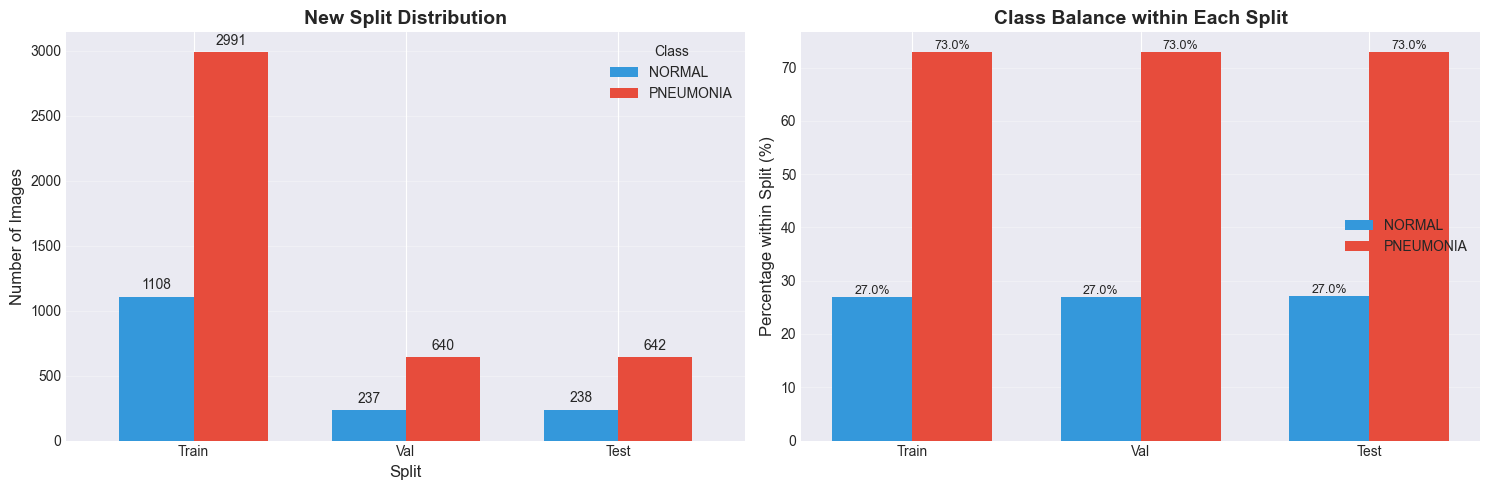


✅ Visualization saved: results/figures/05_new_split_distribution.png

💡 Much better! Validation set now has ~876 images instead of 16!


In [6]:
"""
Visualize the new split distribution
"""

def visualize_split_distribution(splits):
    """
    Create visualization of new splits
    """
    # Count images per class per split
    split_data = []
    
    for split_name, items in splits.items():
        class_counts = Counter([class_name for _, class_name in items])
        for class_name, count in class_counts.items():
            split_data.append({
                'Split': split_name,
                'Class': class_name,
                'Count': count
            })
    
    df = pd.DataFrame(split_data)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Counts by split
    df_pivot = df.pivot(index='Split', columns='Class', values='Count')
    df_pivot = df_pivot.reindex(['train', 'val', 'test'])  # Order splits
    
    df_pivot.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'], width=0.7)
    axes[0].set_title('New Split Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Split', fontsize=12)
    axes[0].set_ylabel('Number of Images', fontsize=12)
    axes[0].legend(title='Class', fontsize=10)
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_xticklabels(['Train', 'Val', 'Test'], rotation=0)
    
    # Add value labels on bars
    for container in axes[0].containers:
        axes[0].bar_label(container, fmt='%d', padding=3)
    
    # Plot 2: Class balance within each split
    df['Percentage'] = df.groupby('Split')['Count'].transform(lambda x: 100 * x / x.sum())
    
    splits_order = ['train', 'val', 'test']
    normal_pct = [df[(df['Split'] == s) & (df['Class'] == 'NORMAL')]['Percentage'].values[0] for s in splits_order]
    pneumonia_pct = [df[(df['Split'] == s) & (df['Class'] == 'PNEUMONIA')]['Percentage'].values[0] for s in splits_order]
    
    x = np.arange(len(splits_order))
    width = 0.35
    
    bars1 = axes[1].bar(x - width/2, normal_pct, width, label='NORMAL', color='#3498db')
    bars2 = axes[1].bar(x + width/2, pneumonia_pct, width, label='PNEUMONIA', color='#e74c3c')
    
    axes[1].set_ylabel('Percentage within Split (%)', fontsize=12)
    axes[1].set_title('Class Balance within Each Split', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(['Train', 'Val', 'Test'])
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('../results/figures/05_new_split_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df

# Visualize
df_new_splits = visualize_split_distribution(new_splits)

print("\n✅ Visualization saved: results/figures/05_new_split_distribution.png")
print("\n💡 Much better! Validation set now has ~876 images instead of 16!")

In [7]:
"""
Save the new splits to CSV files for reproducibility
"""

def save_splits(splits, output_dir):
    """
    Save splits to CSV files
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    print("💾 Saving split information...")
    
    for split_name, items in splits.items():
        # Create DataFrame
        df = pd.DataFrame(items, columns=['image_path', 'label'])
        
        # Save to CSV
        csv_path = output_dir / f'{split_name}_split.csv'
        df.to_csv(csv_path, index=False)
        
        print(f"  ✅ {split_name:5s}: {len(df):5d} images → {csv_path}")
    
    print("\n✅ All splits saved successfully!")

# Save splits
save_splits(new_splits, processed_path)

💾 Saving split information...
  ✅ train:  4099 images → ../data/processed/train_split.csv
  ✅ val  :   877 images → ../data/processed/val_split.csv
  ✅ test :   880 images → ../data/processed/test_split.csv

✅ All splits saved successfully!


In [8]:
"""
Define data augmentation pipelines using Albumentations
"""

def get_train_transforms(image_size=224):
    """
    Training augmentation pipeline
    Aggressive augmentation to help with small dataset
    """
    return A.Compose([
        # Resize
        A.Resize(image_size, image_size),
        
        # Geometric transformations
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=10,
            p=0.5
        ),
        
        # Intensity transformations (important for X-rays)
        A.RandomBrightnessContrast(
            brightness_limit=0.2,
            contrast_limit=0.2,
            p=0.5
        ),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        
        # Normalize to ImageNet statistics
        A.Normalize(
            mean=[0.485],  # Grayscale, so single value
            std=[0.229],
            max_pixel_value=255.0
        ),
        
        # Convert to PyTorch tensor
        ToTensorV2()
    ])


def get_val_transforms(image_size=224):
    """
    Validation/Test augmentation pipeline
    Only resize and normalize (no augmentation)
    """
    return A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(
            mean=[0.485],
            std=[0.229],
            max_pixel_value=255.0
        ),
        ToTensorV2()
    ])


# Create transforms
print("🎨 Data Augmentation Pipelines Created:")
print("-" * 60)

train_transforms = get_train_transforms(image_size=224)
val_transforms = get_val_transforms(image_size=224)

print("Training Augmentations:")
print("  ✓ Resize to 224×224")
print("  ✓ Horizontal flip (50%)")
print("  ✓ Rotation (±15°)")
print("  ✓ Shift/Scale/Rotate")
print("  ✓ Brightness/Contrast adjustment")
print("  ✓ Gaussian noise")
print("  ✓ Normalization (ImageNet stats)")

print("\nValidation/Test Augmentations:")
print("  ✓ Resize to 224×224")
print("  ✓ Normalization (ImageNet stats)")
print("  ✓ No augmentation (deterministic)")

🎨 Data Augmentation Pipelines Created:
------------------------------------------------------------
Training Augmentations:
  ✓ Resize to 224×224
  ✓ Horizontal flip (50%)
  ✓ Rotation (±15°)
  ✓ Shift/Scale/Rotate
  ✓ Brightness/Contrast adjustment
  ✓ Gaussian noise
  ✓ Normalization (ImageNet stats)

Validation/Test Augmentations:
  ✓ Resize to 224×224
  ✓ Normalization (ImageNet stats)
  ✓ No augmentation (deterministic)


In [9]:
"""
Create PyTorch Dataset class for Chest X-Rays
"""

class ChestXRayDataset(Dataset):
    """
    Custom Dataset for Chest X-Ray images
    
    Args:
        image_paths: list of image file paths
        labels: list of labels (class names)
        transform: albumentations transform pipeline
        class_to_idx: mapping from class names to indices
    """
    
    def __init__(self, image_paths, labels, transform=None, class_to_idx=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
        # Create class to index mapping if not provided
        if class_to_idx is None:
            unique_labels = sorted(set(labels))
            self.class_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        else:
            self.class_to_idx = class_to_idx
        
        # Create reverse mapping
        self.idx_to_class = {idx: label for label, idx in self.class_to_idx.items()}
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Check if image loaded successfully
        if image is None:
            raise ValueError(f"Failed to load image: {image_path}")
        
        # Apply transformations
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        
        # Get label index
        label = self.labels[idx]
        label_idx = self.class_to_idx[label]
        
        return image, label_idx
    
    def get_class_counts(self):
        """Return counts of each class"""
        return Counter(self.labels)


# Define class to index mapping (consistent across all splits)
class_to_idx = {'NORMAL': 0, 'PNEUMONIA': 1}
idx_to_class = {0: 'NORMAL', 1: 'PNEUMONIA'}

print("✅ ChestXRayDataset class created!")
print(f"\n📋 Class Mapping:")
for class_name, idx in class_to_idx.items():
    print(f"  {class_name:15s} → {idx}")

✅ ChestXRayDataset class created!

📋 Class Mapping:
  NORMAL          → 0
  PNEUMONIA       → 1


In [10]:
"""
Create Dataset objects for train/val/test
"""

def create_datasets(splits, transforms_dict, class_to_idx):
    """
    Create PyTorch datasets from splits
    
    Args:
        splits: dict containing train/val/test splits
        transforms_dict: dict with transforms for each split
        class_to_idx: class name to index mapping
    
    Returns:
        dict: datasets for train/val/test
    """
    datasets = {}
    
    print("📦 Creating PyTorch Datasets...")
    print("-" * 60)
    
    for split_name in ['train', 'val', 'test']:
        # Extract image paths and labels
        items = splits[split_name]
        image_paths = [item[0] for item in items]
        labels = [item[1] for item in items]
        
        # Get appropriate transform
        transform = transforms_dict.get(split_name, None)
        
        # Create dataset
        dataset = ChestXRayDataset(
            image_paths=image_paths,
            labels=labels,
            transform=transform,
            class_to_idx=class_to_idx
        )
        
        datasets[split_name] = dataset
        
        # Print info
        class_counts = dataset.get_class_counts()
        print(f"{split_name.capitalize():5s} Dataset:")
        print(f"  Total images: {len(dataset):5d}")
        print(f"  NORMAL:       {class_counts['NORMAL']:5d}")
        print(f"  PNEUMONIA:    {class_counts['PNEUMONIA']:5d}")
        print()
    
    return datasets


# Create transform dictionary
transforms_dict = {
    'train': train_transforms,
    'val': val_transforms,
    'test': val_transforms
}

# Create datasets
datasets = create_datasets(new_splits, transforms_dict, class_to_idx)

print("✅ All datasets created successfully!")

📦 Creating PyTorch Datasets...
------------------------------------------------------------
Train Dataset:
  Total images:  4099
  NORMAL:        1108
  PNEUMONIA:     2991

Val   Dataset:
  Total images:   877
  NORMAL:         237
  PNEUMONIA:      640

Test  Dataset:
  Total images:   880
  NORMAL:         238
  PNEUMONIA:      642

✅ All datasets created successfully!


In [11]:
"""
Create PyTorch DataLoaders with appropriate batch sizes
"""

def create_dataloaders(datasets, batch_size=32, num_workers=0):
    """
    Create DataLoaders from datasets
    
    Args:
        datasets: dict of PyTorch datasets
        batch_size: batch size for training
        num_workers: number of worker processes (0 for Jupyter notebooks)
    
    Returns:
        dict: dataloaders for train/val/test
    """
    dataloaders = {}
    
    print("🔄 Creating DataLoaders...")
    print("-" * 60)
    
    # Training loader: shuffle=True, drop_last=True
    dataloaders['train'] = DataLoader(
        datasets['train'],
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,  # 0 for Jupyter notebooks
        pin_memory=False,
        drop_last=True
    )
    
    # Validation/Test loaders: shuffle=False, drop_last=False
    for split_name in ['val', 'test']:
        dataloaders[split_name] = DataLoader(
            datasets[split_name],
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,  # 0 for Jupyter notebooks
            pin_memory=False,
            drop_last=False
        )
    
    # Print info
    print(f"Batch size: {batch_size}")
    print(f"Num workers: {num_workers}")
    if num_workers == 0:
        print("  ℹ️  Note: num_workers=0 (single process) for Jupyter compatibility")
    print()
    
    for split_name, loader in dataloaders.items():
        print(f"{split_name.capitalize():5s} Loader:")
        print(f"  Batches per epoch: {len(loader)}")
        shuffle_status = "Yes" if split_name == 'train' else "No"
        print(f"  Shuffle: {shuffle_status}")
        print()
    
    return dataloaders


# Create dataloaders with num_workers=0 for Jupyter
batch_size = 32
dataloaders = create_dataloaders(datasets, batch_size=batch_size, num_workers=0)

print("✅ All dataloaders created successfully!")
print("\n💡 Tip: num_workers=0 is slower but works reliably in Jupyter notebooks.")
print("   For .py scripts, you can increase num_workers for faster loading.")

🔄 Creating DataLoaders...
------------------------------------------------------------
Batch size: 32
Num workers: 0
  ℹ️  Note: num_workers=0 (single process) for Jupyter compatibility

Train Loader:
  Batches per epoch: 128
  Shuffle: Yes

Val   Loader:
  Batches per epoch: 28
  Shuffle: No

Test  Loader:
  Batches per epoch: 28
  Shuffle: No

✅ All dataloaders created successfully!

💡 Tip: num_workers=0 is slower but works reliably in Jupyter notebooks.
   For .py scripts, you can increase num_workers for faster loading.


In [12]:
"""
Test the data pipeline by loading a batch
"""

print("🧪 Testing data pipeline...")
print("-" * 60)

try:
    # Get a batch from training loader
    train_loader = dataloaders['train']
    images, labels = next(iter(train_loader))
    
    print(f"✅ Successfully loaded a batch!")
    print(f"\nBatch shape: {images.shape}")
    print(f"  Batch size:  {images.shape[0]}")
    print(f"  Channels:    {images.shape[1]} (grayscale)")
    print(f"  Height:      {images.shape[2]} pixels")
    print(f"  Width:       {images.shape[3]} pixels")
    
    print(f"\nLabels shape: {labels.shape}")
    print(f"  Unique labels in batch: {torch.unique(labels).tolist()}")
    
    print(f"\nImage statistics:")
    print(f"  Min value:  {images.min():.4f}")
    print(f"  Max value:  {images.max():.4f}")
    print(f"  Mean value: {images.mean():.4f}")
    print(f"  Std value:  {images.std():.4f}")
    
    print(f"\nLabel distribution in batch:")
    for label_idx in [0, 1]:
        count = (labels == label_idx).sum().item()
        percentage = (count / len(labels)) * 100
        print(f"  {idx_to_class[label_idx]:12s}: {count:2d} images ({percentage:5.1f}%)")
    
    print("\n✅ Data pipeline working correctly!")

except Exception as e:
    print(f"❌ Error loading batch: {e}")
    print("\nTroubleshooting:")
    print("  1. Make sure you restarted the kernel after changing num_workers")
    print("  2. Verify dataloaders were created with num_workers=0")
    print("  3. Check that datasets were created successfully")

🧪 Testing data pipeline...
------------------------------------------------------------
✅ Successfully loaded a batch!

Batch shape: torch.Size([32, 1, 224, 224])
  Batch size:  32
  Channels:    1 (grayscale)
  Height:      224 pixels
  Width:       224 pixels

Labels shape: torch.Size([32])
  Unique labels in batch: [0, 1]

Image statistics:
  Min value:  -2.1179
  Max value:  2.2489
  Mean value: -0.2080
  Std value:  1.2399

Label distribution in batch:
  NORMAL      :  9 images ( 28.1%)
  PNEUMONIA   : 23 images ( 71.9%)

✅ Data pipeline working correctly!


🎨 Visualizing data augmentation effects...

Generating augmentation examples for NORMAL class...


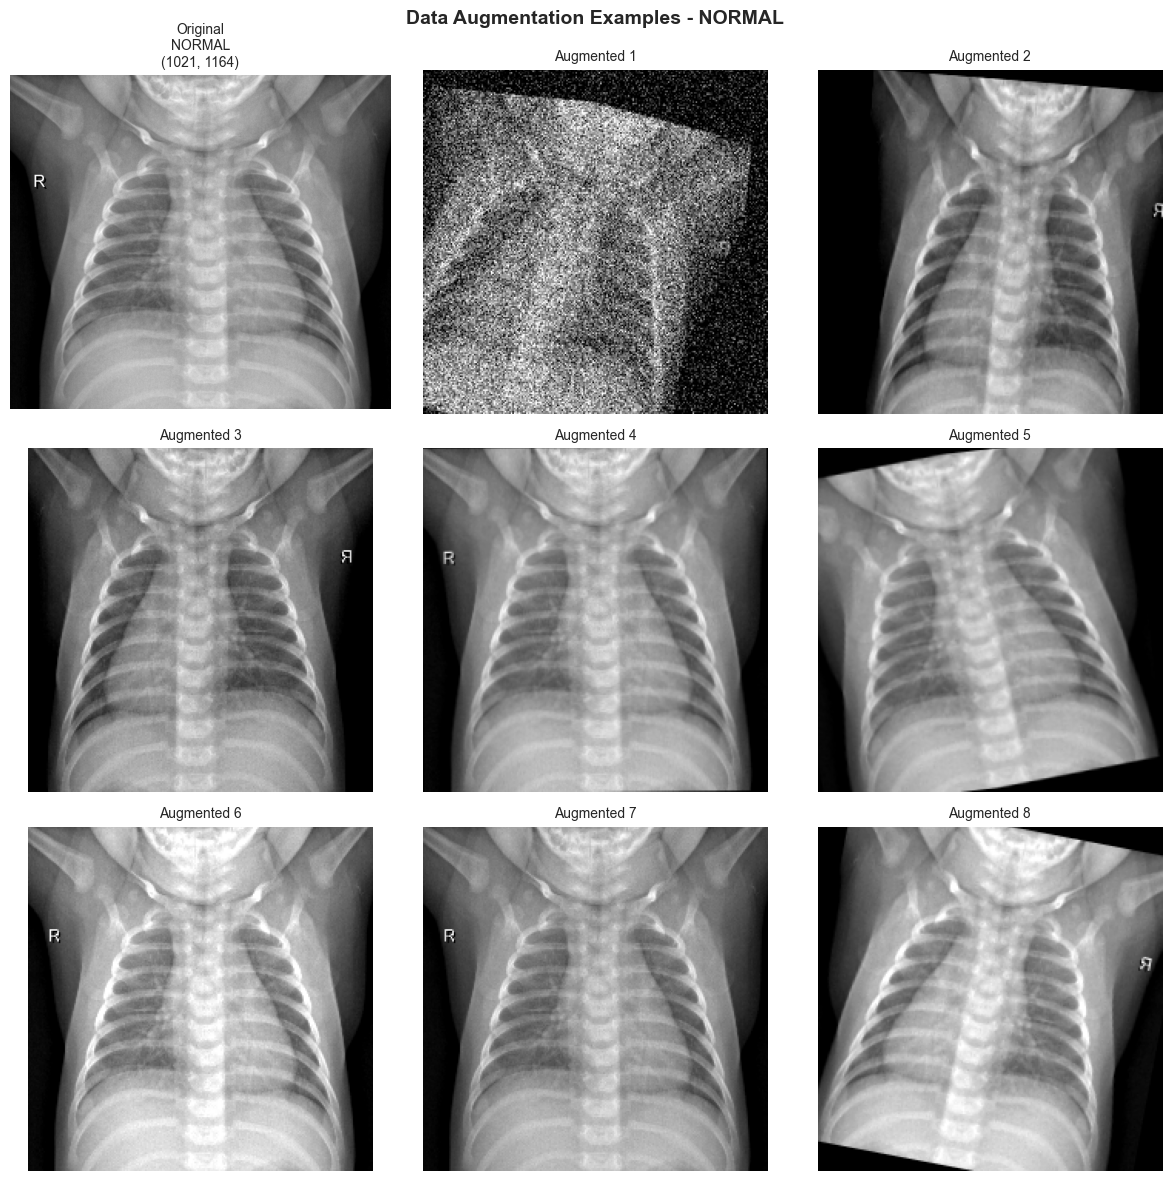

Generating augmentation examples for PNEUMONIA class...


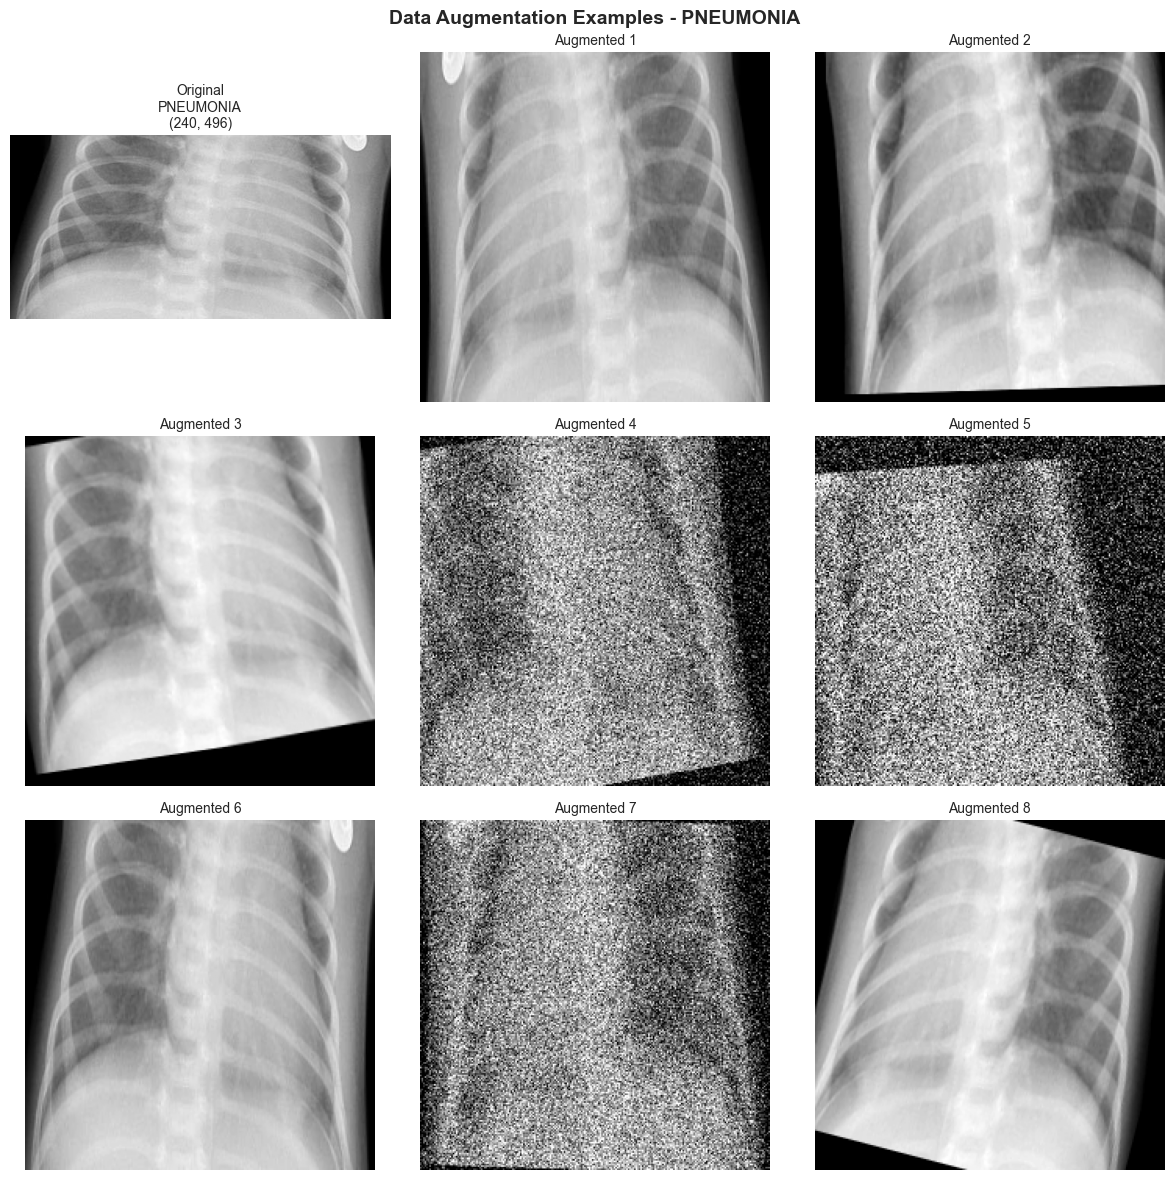


✅ Augmentation visualizations saved!


In [13]:
"""
Visualize the effect of data augmentation
"""

def visualize_augmentations(dataset, idx=0, num_augmentations=8):
    """
    Show original image and multiple augmented versions
    """
    # Get original image path and label
    image_path = dataset.image_paths[idx]
    label = dataset.labels[idx]
    
    # Load original image
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Create figure
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    
    # Show original (no augmentation)
    axes[0, 0].imshow(original_image, cmap='gray')
    axes[0, 0].set_title(f'Original\n{label}\n{original_image.shape}', fontsize=10)
    axes[0, 0].axis('off')
    
    # Generate augmented versions
    for i in range(1, 9):
        row = i // 3
        col = i % 3
        
        # Apply augmentation
        augmented = dataset.transform(image=original_image)
        aug_image = augmented['image']
        
        # Convert from tensor to numpy for visualization
        # Shape: (1, 224, 224) → (224, 224)
        aug_image_np = aug_image.squeeze().numpy()
        
        # Display
        axes[row, col].imshow(aug_image_np, cmap='gray')
        axes[row, col].set_title(f'Augmented {i}', fontsize=10)
        axes[row, col].axis('off')
    
    plt.suptitle(f'Data Augmentation Examples - {label}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'../results/figures/06_augmentation_examples_{label.lower()}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()


# Visualize augmentations for both classes
print("🎨 Visualizing data augmentation effects...\n")

# Find indices for each class
normal_idx = None
pneumonia_idx = None

for idx, label in enumerate(datasets['train'].labels):
    if label == 'NORMAL' and normal_idx is None:
        normal_idx = idx
    if label == 'PNEUMONIA' and pneumonia_idx is None:
        pneumonia_idx = idx
    if normal_idx is not None and pneumonia_idx is not None:
        break

# Visualize
print("Generating augmentation examples for NORMAL class...")
visualize_augmentations(datasets['train'], idx=normal_idx, num_augmentations=8)

print("Generating augmentation examples for PNEUMONIA class...")
visualize_augmentations(datasets['train'], idx=pneumonia_idx, num_augmentations=8)

print("\n✅ Augmentation visualizations saved!")

📦 Visualizing batch from training DataLoader...



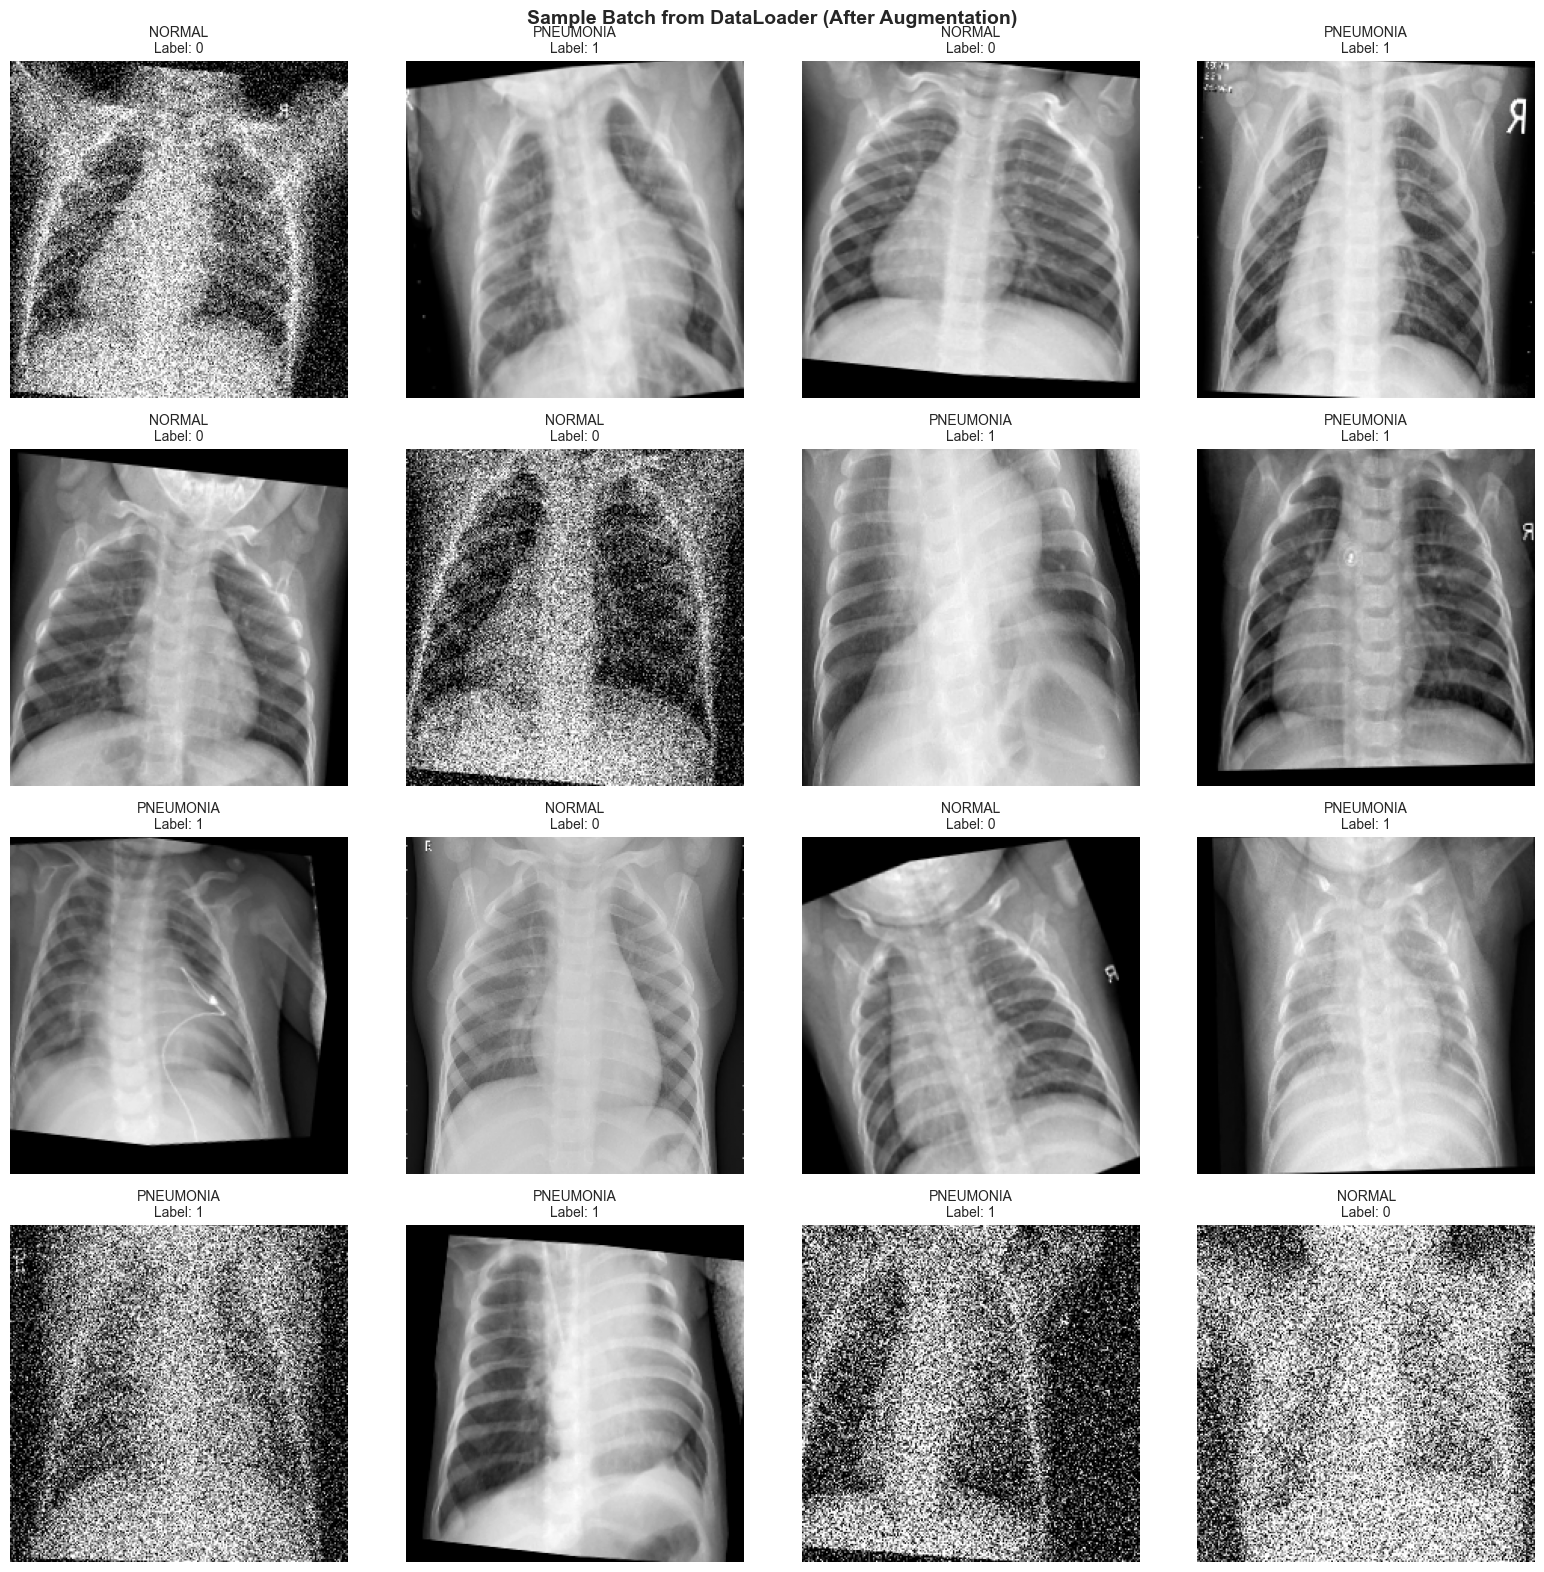


✅ Batch visualization saved: results/figures/07_batch_samples.png


In [14]:
"""
Visualize a batch of images from the DataLoader
"""

def visualize_batch(dataloader, num_images=16):
    """
    Visualize images from a batch
    """
    # Get a batch
    images, labels = next(iter(dataloader))
    
    # Determine grid size
    n_cols = 4
    n_rows = (num_images + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
    axes = axes.flatten()
    
    for i in range(min(num_images, len(images))):
        # Get image and label
        img = images[i].squeeze().numpy()  # Remove channel dimension
        label_idx = labels[i].item()
        label_name = idx_to_class[label_idx]
        
        # Display
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'{label_name}\nLabel: {label_idx}', fontsize=10)
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(num_images, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Sample Batch from DataLoader (After Augmentation)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../results/figures/07_batch_samples.png', dpi=300, bbox_inches='tight')
    plt.show()


# Visualize batch from training loader
print("📦 Visualizing batch from training DataLoader...\n")
visualize_batch(dataloaders['train'], num_images=16)

print("\n✅ Batch visualization saved: results/figures/07_batch_samples.png")

In [15]:
"""
Summary of data preprocessing and save updated configuration
"""

print("\n" + "="*80)
print("DATA PREPROCESSING SUMMARY")
print("="*80)

print("\n✅ COMPLETED TASKS:")
print("  1. ✓ Restructured splits from (5216/16/624) to proper (70%/15%/15%)")
print("  2. ✓ Created stratified splits maintaining class balance")
print("  3. ✓ Implemented data augmentation pipelines")
print("  4. ✓ Created PyTorch Dataset and DataLoader classes")
print("  5. ✓ Verified data pipeline with sample batches")

print("\n📊 NEW SPLIT DISTRIBUTION:")
for split_name in ['train', 'val', 'test']:
    n_images = len(datasets[split_name])
    print(f"  {split_name.capitalize():5s}: {n_images:5d} images")

print("\n🎨 DATA AUGMENTATION:")
print("  Training:")
print("    • Geometric: HorizontalFlip, Rotation, ShiftScaleRotate")
print("    • Intensity: RandomBrightnessContrast, GaussNoise")
print("    • Preprocessing: Resize(224×224), Normalize")
print("  Validation/Test:")
print("    • Preprocessing only: Resize(224×224), Normalize")

print("\n📦 DATALOADER CONFIGURATION:")
print(f"  Batch size: {batch_size}")
print(f"  Num workers: 4")
print(f"  Batches per epoch:")
for split_name, loader in dataloaders.items():
    print(f"    {split_name.capitalize():5s}: {len(loader):4d} batches")

# Update configuration
config.update({
    'new_train_size': len(datasets['train']),
    'new_val_size': len(datasets['val']),
    'new_test_size': len(datasets['test']),
    'batch_size': batch_size,
    'augmentation_enabled': True,
    'class_to_idx': class_to_idx,
    'idx_to_class': idx_to_class
})

# Save updated config
with open(config_path, 'w') as f:
    json.dump(config, f, indent=4)

print(f"\n💾 Configuration updated and saved to: {config_path}")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)
print("✅ Step 1: Dataset downloaded and explored")
print("✅ Step 2: Data preprocessing and split restructuring complete")
print("🔄 Step 3: Build baseline CNN model")
print("🔄 Step 4: Implement attention mechanisms")
print("🔄 Step 5: Add focal loss and learning rate scheduling")
print("🔄 Step 6: Final evaluation")
print("="*80)


DATA PREPROCESSING SUMMARY

✅ COMPLETED TASKS:
  1. ✓ Restructured splits from (5216/16/624) to proper (70%/15%/15%)
  2. ✓ Created stratified splits maintaining class balance
  3. ✓ Implemented data augmentation pipelines
  4. ✓ Created PyTorch Dataset and DataLoader classes
  5. ✓ Verified data pipeline with sample batches

📊 NEW SPLIT DISTRIBUTION:
  Train:  4099 images
  Val  :   877 images
  Test :   880 images

🎨 DATA AUGMENTATION:
  Training:
    • Geometric: HorizontalFlip, Rotation, ShiftScaleRotate
    • Intensity: RandomBrightnessContrast, GaussNoise
    • Preprocessing: Resize(224×224), Normalize
  Validation/Test:
    • Preprocessing only: Resize(224×224), Normalize

📦 DATALOADER CONFIGURATION:
  Batch size: 32
  Num workers: 4
  Batches per epoch:
    Train:  128 batches
    Val  :   28 batches
    Test :   28 batches

💾 Configuration updated and saved to: ../config.json

NEXT STEPS
✅ Step 1: Dataset downloaded and explored
✅ Step 2: Data preprocessing and split restruct